# Retail Image Search Using Milvus  

While most consumers believe that they enjoy a variety of diverse products, this is often not true. Research sugessts that human preferenaces in music and clothing usually revolve around what they are used to. That means that if you are looking to buy a brand new dress or pair of pants, you are likely to purchase an item which resemebles the one you have previously purched-whether or not you are aware of it.

One application for Milvus is an image similarity search engine that allows consumers to pick items that are most similar in style to the ones that they prefer. A simple "black dress" search may return black dresses of a variety of different styles, yet Milvus can search thousands of images to help consumers focus in on specific styles of interest in an efficient, computationally-cost-friendly way. 


Simply begin by importing the neccesary libaries. We'll start by using PyTorch.

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Preprocessing 

#### Next step is to begin standard image preprocessing. Create a class to extract the feature vectors.

In [2]:
class FeatureVector(object):
    def __init__(self):
        self.model = models.resnet18(pretrained=True)
        self.model.eval()
        self.layer = self.model._modules.get("avgpool")
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        self.transform_pipeline = transforms.Compose([transforms.Resize((224, 224)),
                                                      transforms.ToTensor(),
                                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                           std=[0.229, 0.224, 0.225])])       
    def get_vector(self, img):
        t_img = Variable(self.transform_pipeline(img)).unsqueeze(0)
        feat_vec = torch.zeros(512)

        def copy_data(m, i, o):
            feat_vec.copy_(o.data.squeeze())

        h = self.layer.register_forward_hook(copy_data)
        self.model(t_img)
        h.remove()

        return feat_vec
    
    def similarity(self, a, b):
        return self.cos(a.unsqueeze(0), b.unsqueeze(0))

#### We will use ten dress images for comparison and take a look at their similarity. 

Similarity: tensor([0.8408])


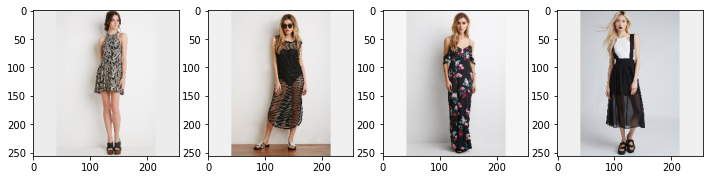

In [15]:
feat_vec = FeatureVector()
one = Image.open('./images/1.jpg')
two = Image.open('./images/2.jpg')
three = Image.open('./images/3.jpg')
four = Image.open('./images/4.jpg')
five = Image.open('./images/5.jpg')
six = Image.open('./images/6.jpg')
seven= Image.open('./images/7.jpg')
eight= Image.open('./images/8.jpg')
nine= Image.open('./images/9.jpg')
ten= Image.open('./images/10.jpg')


def compare(a, b, c, d):
    plt.figure(figsize = (12,12))
    plt.subplot(1, 4, 1)
    plt.imshow(a)
    plt.subplot(1, 4, 2)
    plt.imshow(b)
    plt.subplot(1, 4, 3)
    plt.imshow(c)
    plt.subplot(1, 4, 4)
    plt.imshow(d)
    a_v = feat_vec.get_vector(a)
    b_v = feat_vec.get_vector(b)
    c_v = feat_vec.get_vector(c)
    d_v = feat_vec.get_vector(d)
    print('Similarity: {}'.format(feat_vec.similarity(a_v, b_v)))
    
compare(six, eight, two, five)


We can see here that each vector has 512 dimensions. 

In [4]:
one_vec = feat_vec.get_vector(one)
one_vec.shape

torch.Size([512])

## Connecting to Milvus 

#### Now comes the fun part of incorporating Milvus. First, you need to connect to the Milvus server then build a collection.

NOTE: You will most likely get a timeout error when you try to run this if you are using a Mac and have not changed any Docker settings. Make sure that under Docker-->Preferences->Resources your memory is set to at least 5GB.

Also, make sure you are using the correct port and double check that your Milvus container up and running in Docker. 

In [5]:
from milvus import Milvus, IndexType, MetricType, Status
# Milvus server IP address and port.
# Because the link to milvus in docker-compose 
# was named `milvus`, thats what the hostname will be
_HOST = 'localhost'
_PORT = '19530'  # default value
# Vector parameters
_DIM = 512  # dimension of vector
_INDEX_FILE_SIZE = 32  # max file size of stored index
milvus = Milvus(_HOST, _PORT, pool_size=10)

# Create collection demo_collection if it dosen't exist.
collection_name = 'resnet18_simple'

status, ok = milvus.has_collection(collection_name)
if not ok:
    param = {
        'collection_name': collection_name,
        'dimension': _DIM,
        'index_file_size': _INDEX_FILE_SIZE,  # optional
        'metric_type': MetricType.L2  # optional
    }

    print(milvus.create_collection(param))

Status(code=0, message='Create collection successfully!')


#### We used resnet18 because if has rich feature representations for a wide range of images.

In [6]:
_, collection = milvus.get_collection_info(collection_name)
print(collection)

CollectionSchema(collection_name='resnet18_simple', dimension=512, index_file_size=32, metric_type=<MetricType: L2>)


## Inserting Feature Vectors 

#### Convert the feature vectors into Python lists and print the Milvus image ID's.

In [7]:
images = [
    one,
    two,
    three,
    four,
    five,
    six,
    seven, eight, nine, ten
]
# 10000 vectors with 128 dimension
# element per dimension is float32 type
# vectors should be a 2-D array
vectors = [feat_vec.get_vector(i).tolist() for i in images]
# Insert vectors into demo_collection, return status and vectors id list
status, ids = milvus.insert(collection_name, records=vectors)
if not status.OK():
    print("Insert failed: {}".format(status))
else: print(ids)

[1599963148228651000, 1599963148228651001, 1599963148228651002, 1599963148228651003, 1599963148228651004, 1599963148228651005, 1599963148228651006, 1599963148228651007, 1599963148228651008, 1599963148228651009]


#### With this loop, we'll print a table with the image ID's and information about each image. 

In [8]:
lookup = {}
for ID, img in zip(ids, images):
    lookup[ID] = img
    
for k in lookup:
    print(k, lookup[k])

1599963148228651000 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x125B46150>
1599963148228651001 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x125B98490>
1599963148228651002 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x125B98890>
1599963148228651003 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x125B98990>
1599963148228651004 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x125B98A90>
1599963148228651005 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x125B98B90>
1599963148228651006 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x125B98C90>
1599963148228651007 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x125B98D90>
1599963148228651008 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x125B98E90>
1599963148228651009 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x125B98F90>


#### Next, you can flush in the data from the collection to make it available. Milvus does this automatically. 

In [9]:
# Flush collection  inserted data to disk.
milvus.flush([collection_name])
# Get demo_collection row count
status, result = milvus.count_entities(collection_name)
print(result)
# present collection statistics info
_, info = milvus.get_collection_stats(collection_name)
print(info)



10
{'partitions': [{'row_count': 10, 'segments': [{'data_size': 20560, 'index_name': 'IDMAP', 'name': '1599963148233510000', 'row_count': 10}], 'tag': '_default'}], 'row_count': 10}


#### Create an index. 

In [10]:
# create index of vectors, search more rapidly
index_param = {
    'nlist': 2048
}

# Create ivflat index in demo_collection
# You can search vectors without creating index. however, Creating index help to
# search faster
print("Creating index: {}".format(index_param))
status = milvus.create_index(collection_name, IndexType.IVF_FLAT, index_param)

# describe index, get information of index
status, index = milvus.get_index_info(collection_name)
print(index)

Creating index: {'nlist': 2048}
(collection_name='resnet18_simple', index_type=<IndexType: IVFLAT>, params={'nlist': 2048})


In [11]:
_, info = milvus.get_collection_stats(collection_name)
print(info)

# Obtain raw vectors by providing vector ids
status, result_vectors = milvus.get_entity_by_id(collection_name, ids[:8])

# create index of vectors, search more rapidly
index_param = {
'nlist': 2048
}


{'partitions': [{'row_count': 10, 'segments': [{'data_size': 20560, 'index_name': 'IDMAP', 'name': '1599963148233510000', 'row_count': 10}], 'tag': '_default'}], 'row_count': 10}


## Preforming the Search and Creating Visuals

In [12]:
search_param = {
    "nprobe": 16
}

print("Searching ... ")

param = {
    'collection_name': collection_name,
    'query_records': [vectors[0]],
    'top_k': 10,
    'params': search_param,
}

status, results = milvus.search(**param)
if status.OK():
    print(results)
else:
    print("Search failed. ", status)

Searching ... 
[
[
(id:1599963148228651000, distance:0.0),
(id:1599963148228651004, distance:118.04978942871094),
(id:1599963148228651002, distance:129.69686889648438),
(id:1599963148228651008, distance:226.12881469726562),
(id:1599963148228651006, distance:229.18447875976562),
(id:1599963148228651005, distance:236.20260620117188),
(id:1599963148228651009, distance:239.573974609375),
(id:1599963148228651007, distance:258.564453125),
(id:1599963148228651003, distance:287.48333740234375),
(id:1599963148228651001, distance:377.0762939453125)
]
]


#### We can use the loop below to visualize results. It is interesting to note here that color alone does note determine greater similarity. This would allow consumers to perform searches for styles and items that they may not even be able to describe, and your organization can give them this ability in a conveneient way using Milvus. 

Distance: 0.0
Distance: 118.04978942871094
Distance: 129.69686889648438
Distance: 226.12881469726562
Distance: 229.18447875976562
Distance: 236.20260620117188
Distance: 239.573974609375
Distance: 258.564453125
Distance: 287.48333740234375
Distance: 377.0762939453125


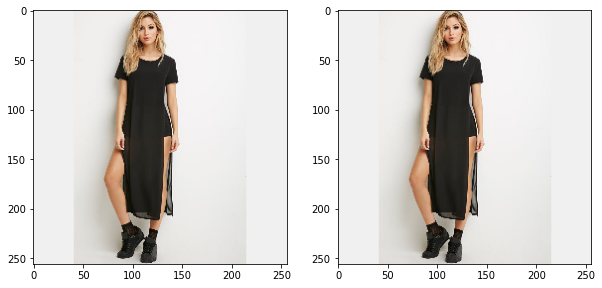

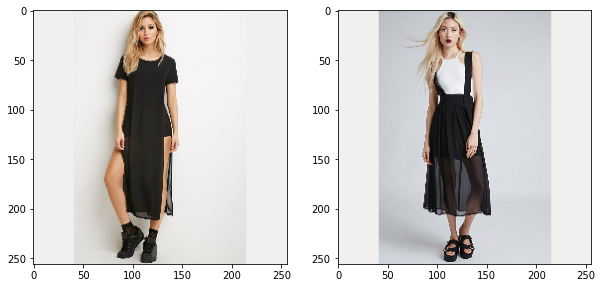

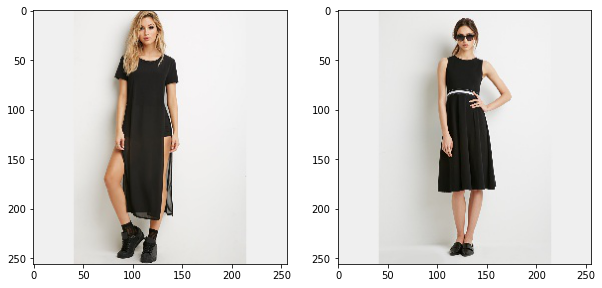

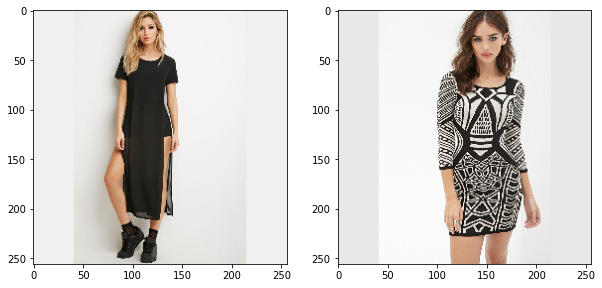

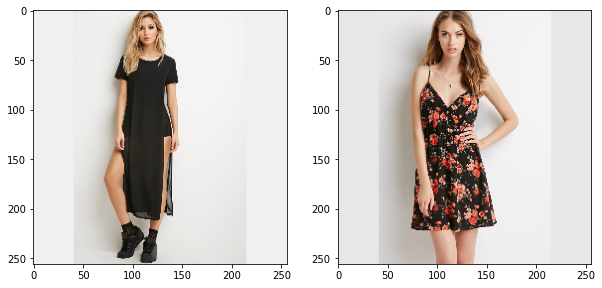

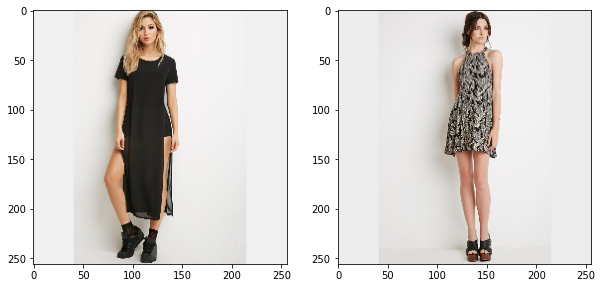

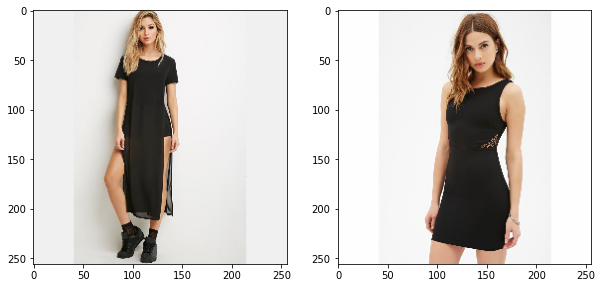

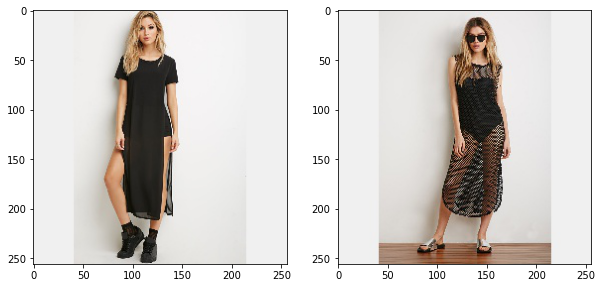

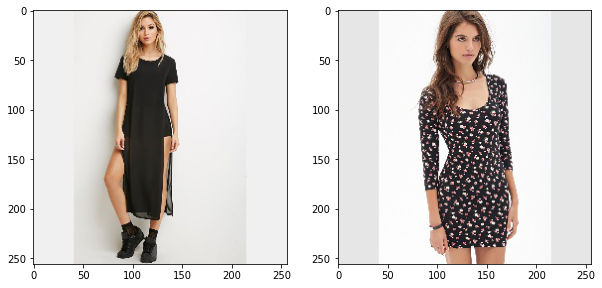

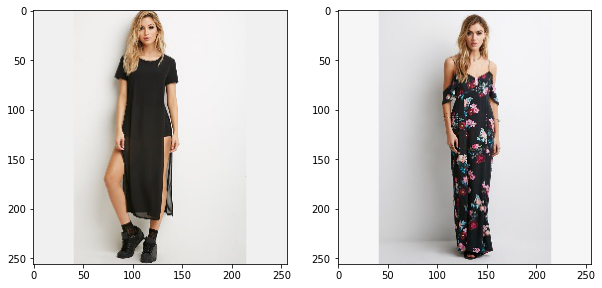

In [13]:
for neighbors in results:
    for n in neighbors:
        plt.figure(figsize = (10,10))
        plt.subplot(1, 2, 1)
        plt.imshow(images[0])
        plt.subplot(1, 2, 2)
        plt.imshow(lookup[n.id])
        print('Distance: {}'.format(n.distance))

#### Lastly, drop the collection.

In [14]:
milvus.drop_collection(collection_name)


Status(code=0, message='Delete collection successfully!')